### 회귀 실습 - 자전거 대여 수요 예측

In [41]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
# 데이터 준비
FILE = '../data/bike_train.csv'
bikedf=pd.read_csv(FILE)
bikedf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [42]:
# 문자열을 datetime 타입으로 변경
bikedf['datetime'] = bikedf.datetime.apply(pd.to_datetime)

# date 타입에서 년, 월, 일, 시간 추출
bikedf['year'] = bikedf.datetime.apply(lambda x:x.year)
bikedf['month'] = bikedf.datetime.apply(lambda x:x.month)
bikedf['day'] = bikedf.datetime.apply(lambda x:x.day)
bikedf['hour'] = bikedf.datetime.apply(lambda x:x.hour)
bikedf.head(3)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


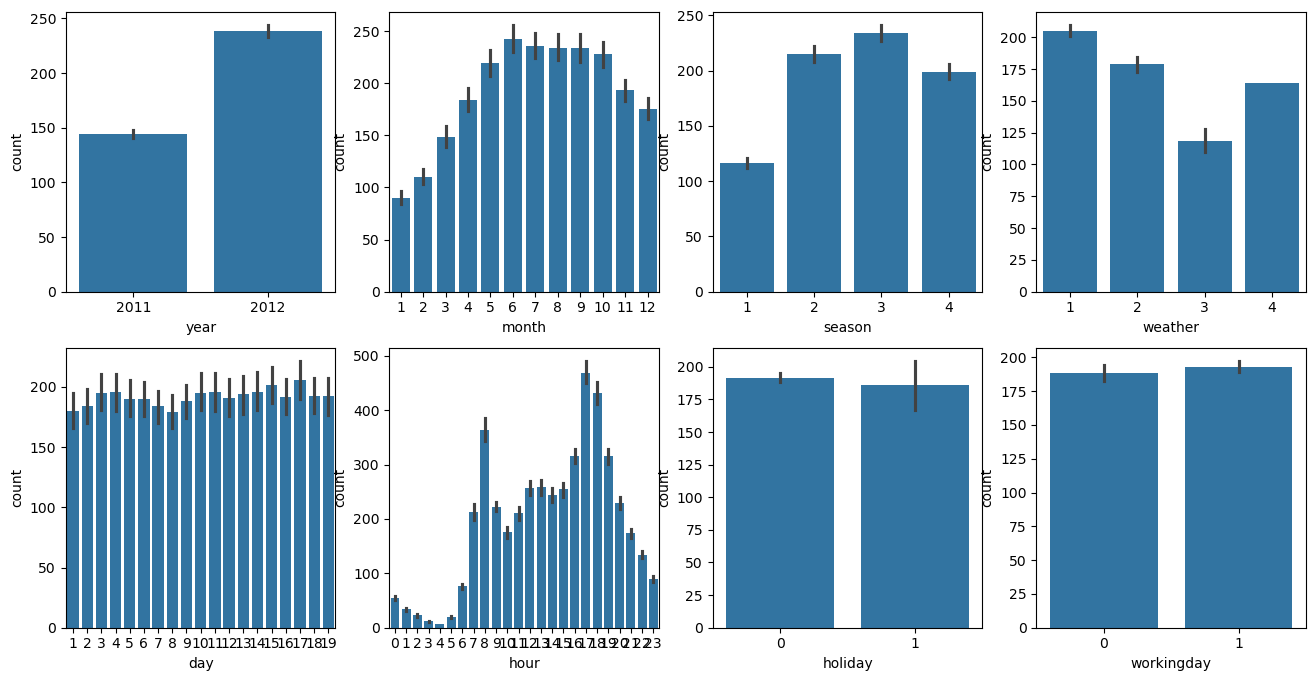

In [43]:
drop_columns = ['datetime','casual', 'registered']
bikedf.drop(drop_columns, axis=1, inplace=True)

fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']

# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4

    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bikedf, ax=axs[row][col])

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE계산
def rmsle(y, pred):
    log_y= np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [45]:
# 로그 변환, 피처 인코딩과 모델 학습/예측/평가
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bikedf['count']
X_features = bikedf.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [46]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    # 예측값과 실제 값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

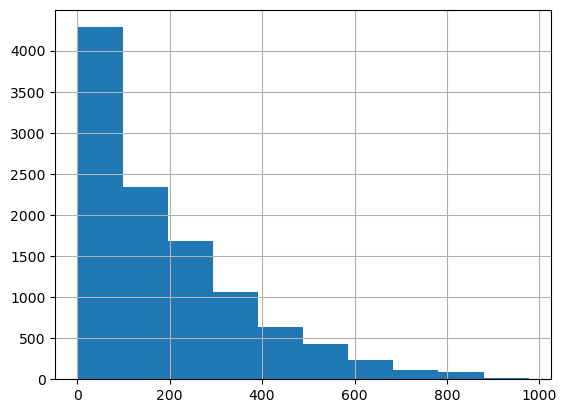

In [47]:
y_target.hist()

<Axes: >

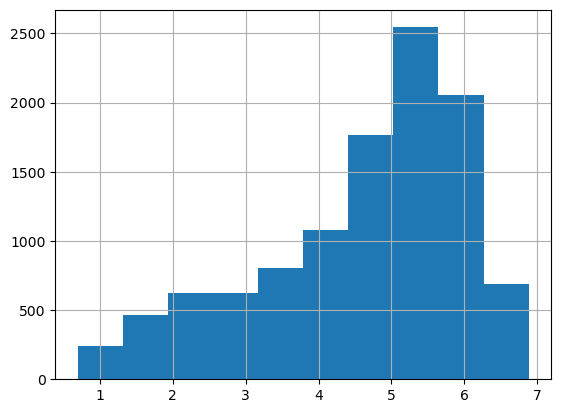

In [48]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [49]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환 됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습 돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<Axes: ylabel='None'>

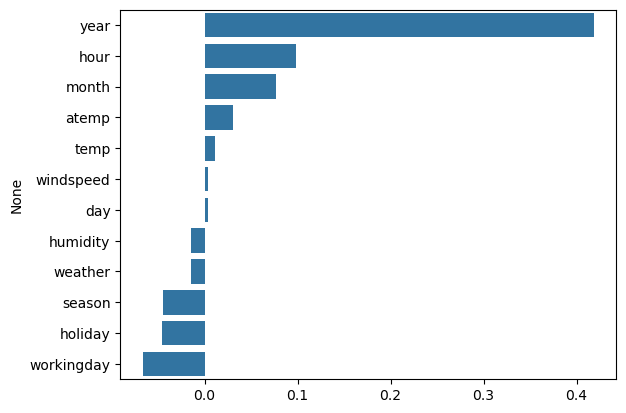

In [50]:
# 각 피처의 회귀 계숫값을 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [51]:
# year, month, day, hour 등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday','season', 'weather'])

In [52]:
# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.690, MAE: 63.383
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<Axes: ylabel='None'>

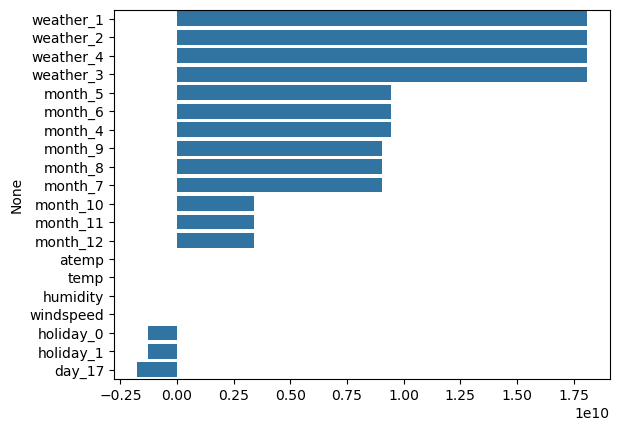

In [53]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

### 캐글 주택 가격 : 고급 회귀 기법

In [54]:
# 데이터 사전 처리 preprocessing
import warnings
warnings.filterwarnings('ignore')

FILE2 = '../data/house_price.csv'
housedf=pd.read_csv(FILE2)

In [55]:
print('데이터 세트의 shape:', housedf.shape)
print('\n전체 피처의 type \n', housedf.dtypes.value_counts())
isnull_series = housedf.isnull().sum()
print('\n Null 칼럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

 Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


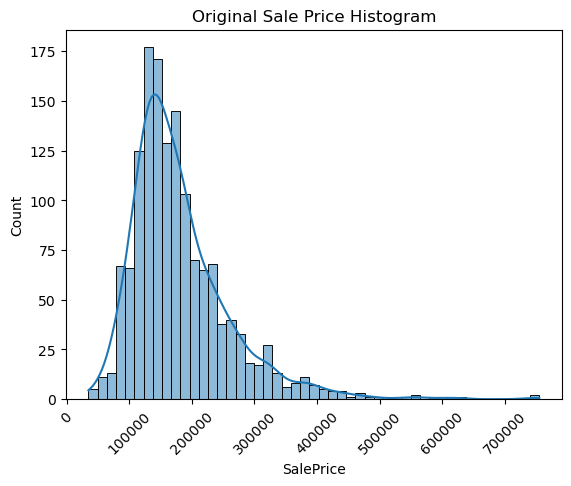

In [56]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(housedf['SalePrice'], kde=True)
plt.show()

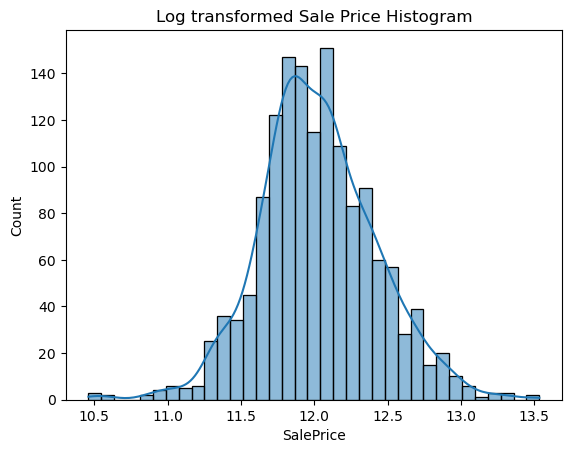

In [57]:
plt.title('Log transformed Sale Price Histogram')
log_SalePrice = np.log1p(housedf['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [59]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

FILE2 = '../data/house_price.csv'
housedf=pd.read_csv(FILE2)
housedf

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [60]:
print('데이터 세트의 shape:', housedf.shape)
print('\n 전체 피처의 type \n', housedf.dtypes.value_counts())
isnull_series = housedf.isnull().sum()
print('\n Null 칼럼과 그 건수 :\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 shape: (1460, 81)

 전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

 Null 칼럼과 그 건수 :
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


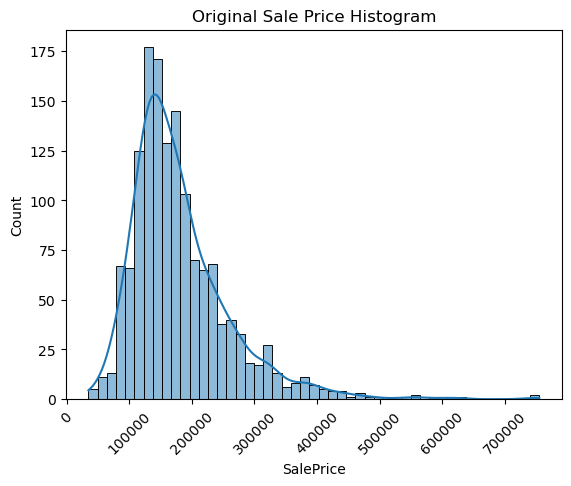

In [61]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(housedf['SalePrice'], kde=True)
plt.show()

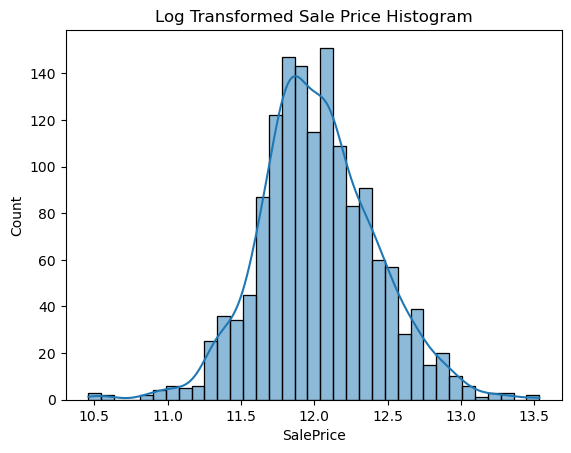

In [62]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(housedf['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show('Id', 'PoolQC', 'MiscFeature', 'Alley')

In [ ]:
# SalePrice 로그 변환
original_SalePrice = housedf['SalePrice']
housedf['SalePrice'] = np.log1p(housedf['SalePrice'])
housedf.drop([''])